In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

import warnings

In [45]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [46]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [48]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

**There are no NaN values that we need to be considerate of**

[0.09616975 0.02736114 0.07681339 0.03252193 0.13034022 0.02416886
 0.06875607 0.1208205  0.08276899 0.0267833  0.02765482 0.28584103]


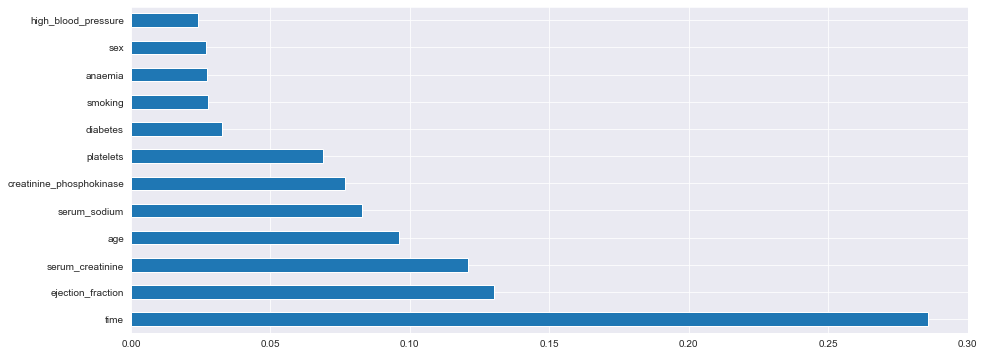

In [49]:
# Feature Selection

plt.rcParams['figure.figsize']=15,6 
sns.set_style("darkgrid")

#Selecting all the features except for the target feature ('DEATH_EVENT')
X = data.iloc[:, :-1]

#Selecting the target feature ('DEATH_EVENT')
y = data.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

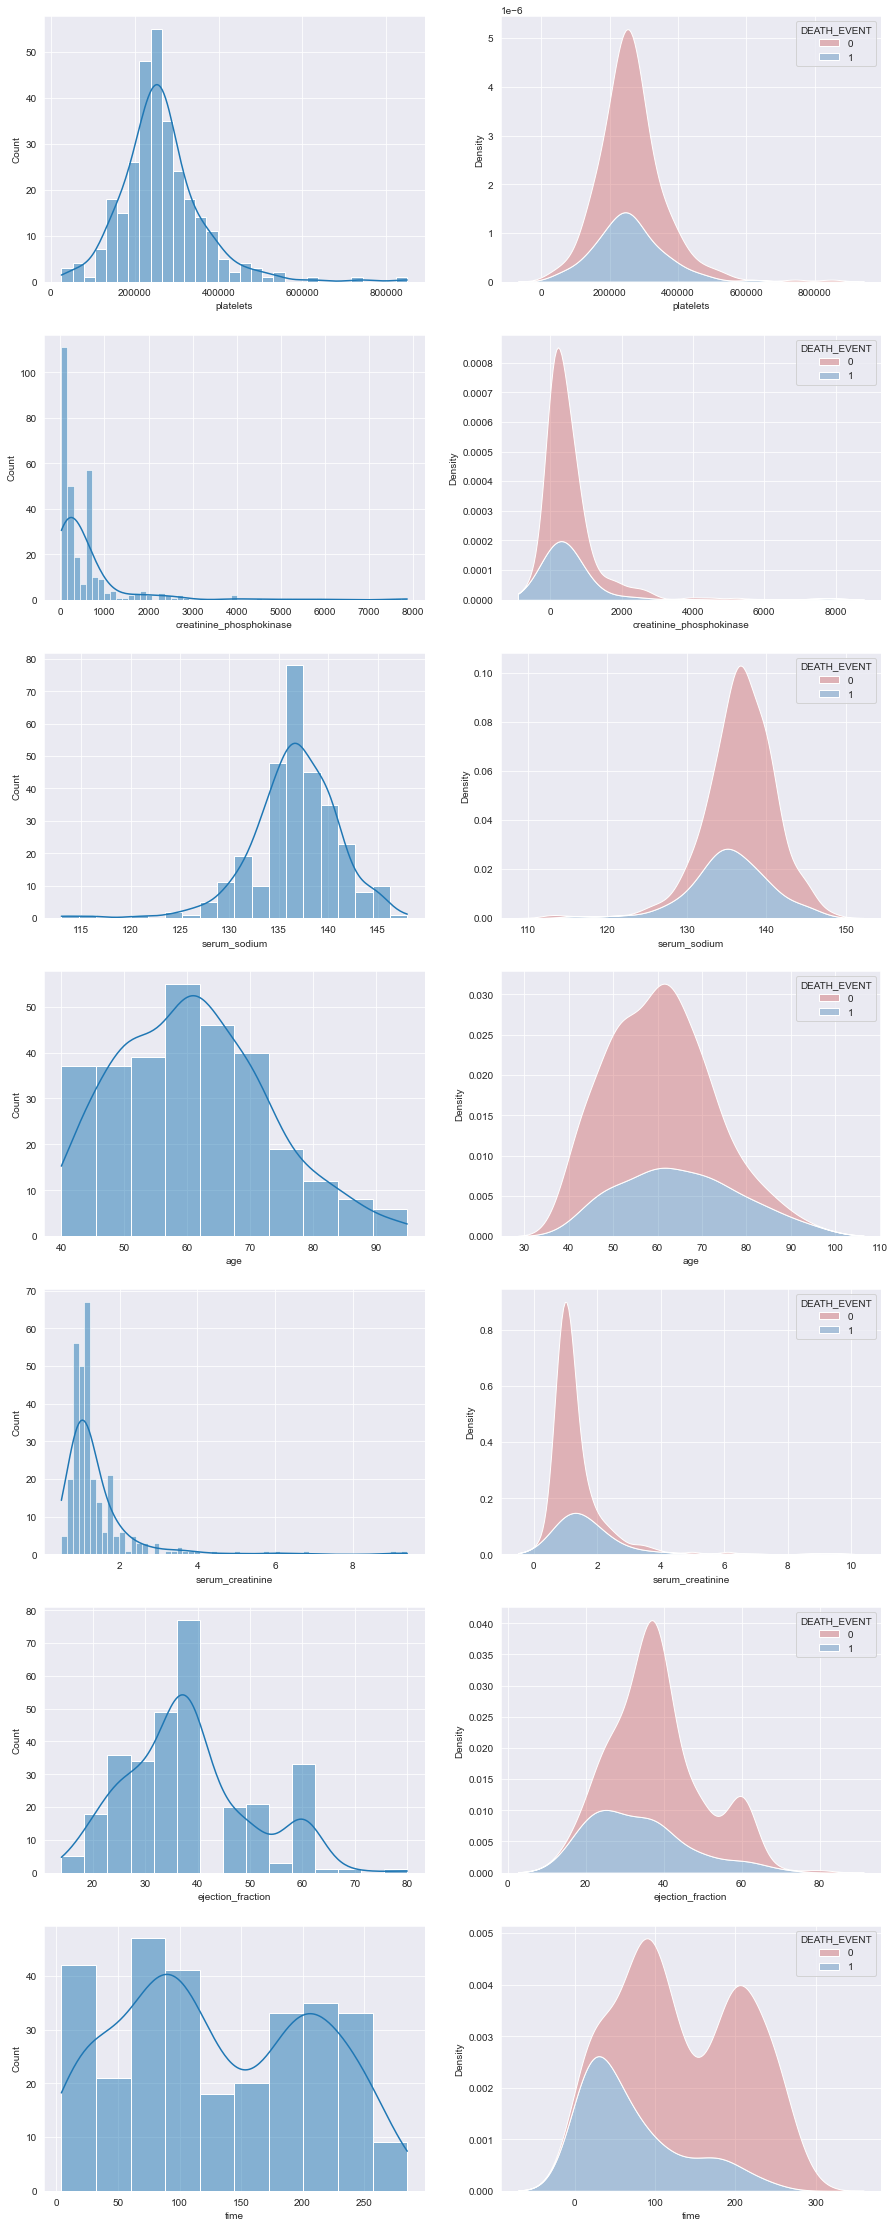

In [50]:
#Creating a list of features from the dataset to iterate through 
features = ['platelets', 'creatinine_phosphokinase', 'serum_sodium', 'age', 'serum_creatinine', 'ejection_fraction', 'time']

#Establishing plots and plot sizes
fig, ax = plt.subplots(ncols=2, nrows=7, figsize=(15, 40))
i = 0

#Creating loop to generate KDE plot and histogram for each feature
for col in features: 
    sns.histplot(data, x=col, kde=True, ax = ax[i,0]) 
    
    #Setting hue as 'Potability' to see how it is affected
    sns.kdeplot(data[col], fill=True, alpha=0.4, hue = data.DEATH_EVENT, 
    palette=('indianred', 'steelblue'), multiple='stack', ax=ax[i,1])
    
    i = i + 1

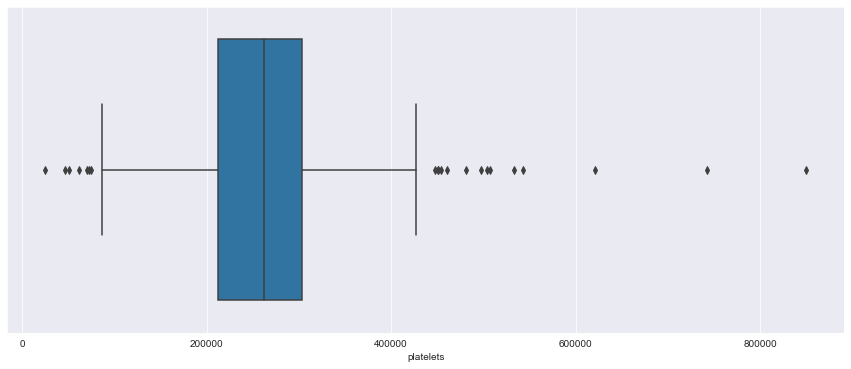

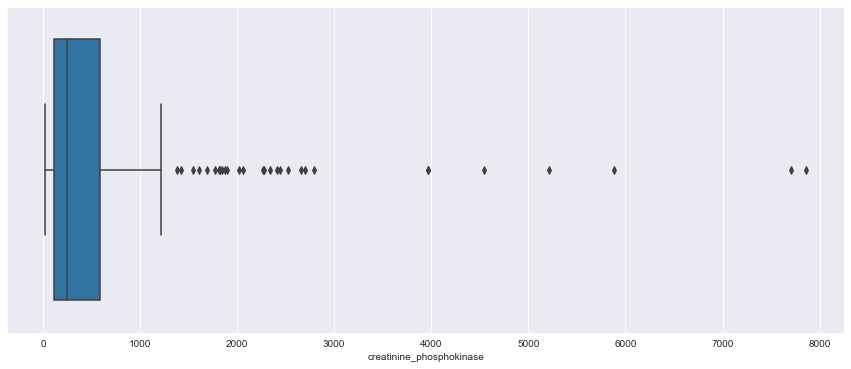

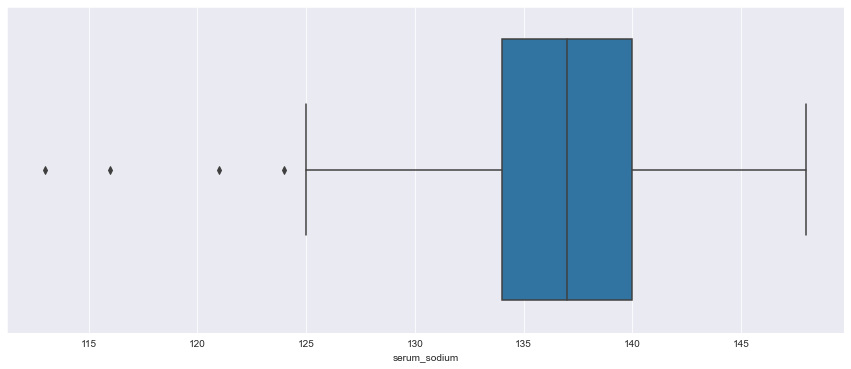

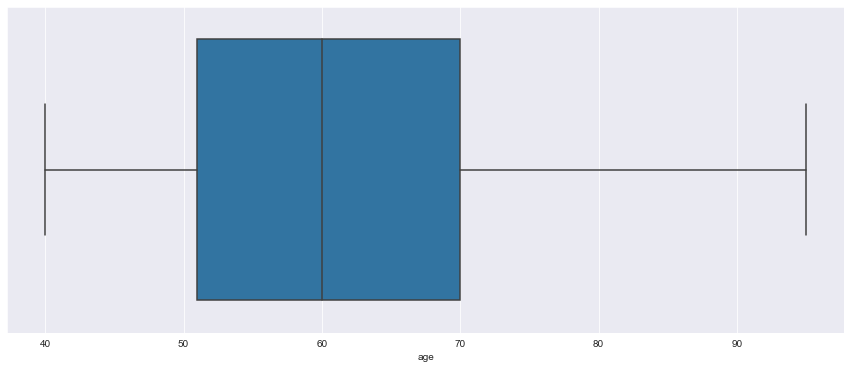

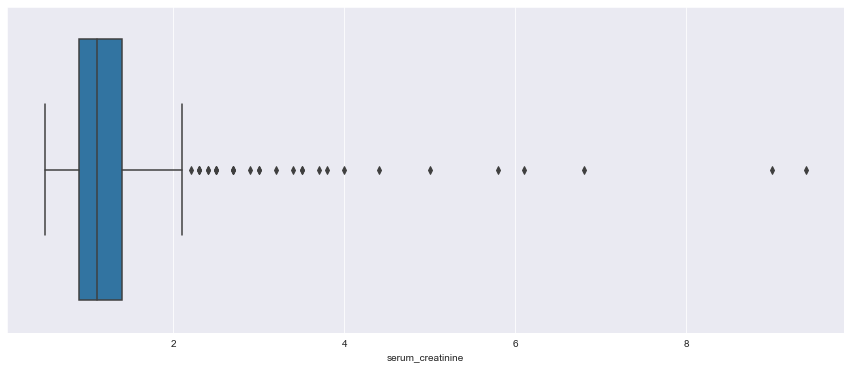

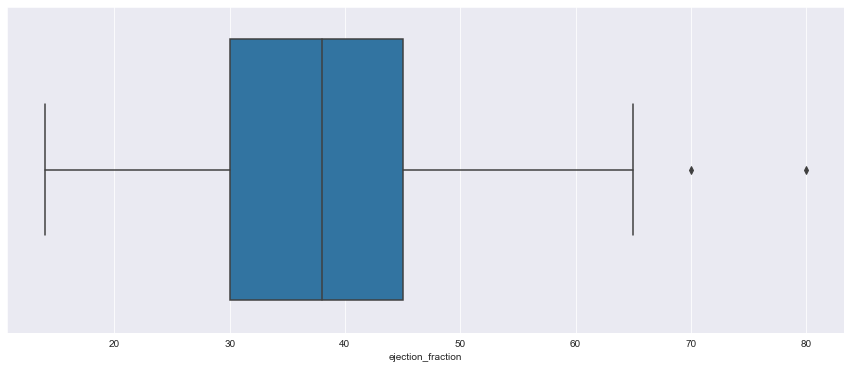

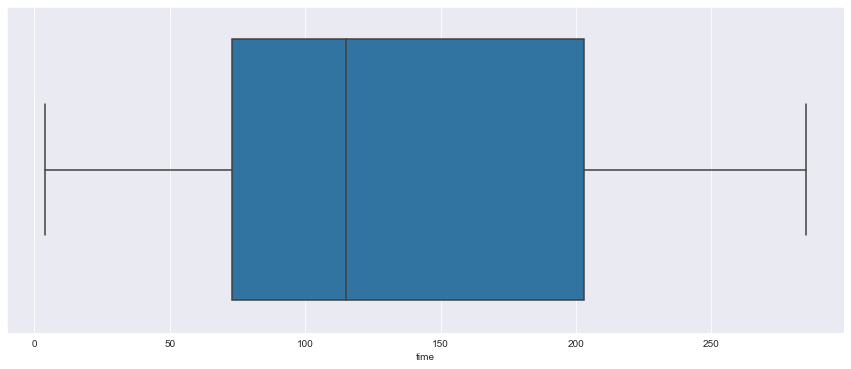

In [51]:
for feature in features:
    sns.boxplot(x = data[feature])
    plt.show()

<AxesSubplot:>

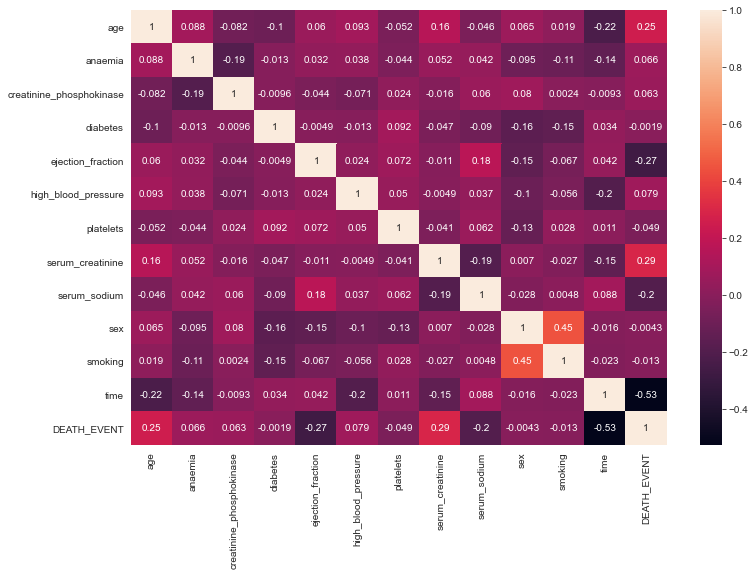

In [52]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(), annot = True)

## Train Test Split

In [53]:
features = ['platelets', 'creatinine_phosphokinase', 'serum_sodium', 'age', 'serum_creatinine', 'ejection_fraction', 'time']

X = data[features]
y = data['DEATH_EVENT']

standard_scaler = StandardScaler()
standard_scaler.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)


## SMOTE

In [54]:
#Instantiating the SMOTE function
smt = SMOTE()

#Getting a count of the pre-smote data
pre_smt_counter = Counter(y_train)

#Resampling the data with the SMOTE
X_train, y_train = smt.fit_resample(X_train, y_train)

#Getting a count of the post-smote data
post_smt_counter = Counter(y_train)

#Printing the results
print('Before SMOTE', pre_smt_counter)
print('After SMOTE', post_smt_counter)

Before SMOTE Counter({0: 157, 1: 82})
After SMOTE Counter({0: 157, 1: 157})


## Testing Generic Model Performance

In [55]:
#List of models to be tested
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), 
         KNeighborsClassifier(), BaggingClassifier(), SVC()]

kf = KFold(n_splits = 10)

#Empty lists to append for analysis
mod = []
precision_score = []
accuracy_score = []
f1_score = []

#Creating a for loop to test all models with generic parameters
for m in models:
    accuracy_score.append(cross_val_score(m, X_train, y_train, scoring = 'accuracy', cv = kf, n_jobs = -1).mean())
    f1_score.append(cross_val_score(m, X_train, y_train, scoring = 'f1', cv = kf, n_jobs = -1).mean())
    precision_score.append(cross_val_score(m, X_train, y_train, scoring = 'precision', cv = kf, n_jobs = -1).mean())
    mod.append(m)

#Creating the DataFrame for analysis
model_df = pd.DataFrame(columns = ['model', 'precision',  'accuracy', 'f1'])
model_df['model'] = mod
model_df['precision'] = precision_score
model_df['accuracy'] = accuracy_score
model_df['f1'] = f1_score
model_df.sort_values(by=['accuracy'], ascending = False).style.background_gradient(subset='accuracy')

,model,precision,accuracy,f1
1,RandomForestClassifier(),0.837504,0.878931,0.846342
2,GradientBoostingClassifier(),0.850196,0.869758,0.845011
4,BaggingClassifier(),0.816432,0.837399,0.800733
0,LogisticRegression(),0.727367,0.767440,0.747670
3,KNeighborsClassifier(),0.568314,0.627419,0.573344
5,SVC(),0.572300,0.514214,0.371832


## Hyperparameter Tuning Random Forest Classifier

In [56]:
#Hyperparameters to manipulate

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

#Number of features to be considered at every split
max_features = ['auto', 'sqrt']

#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 110, num = 10)]

#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

#Method of selecting samples for training each tree
bootstrap = [True, False]

#Creating the param grid
rf_param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap': bootstrap}

In [57]:
#Instantiateing the RandomForestClassifier
rf = RandomForestClassifier()

#Instantiating the RandomGrid
rf_grid = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_grid, scoring = 'accuracy', cv = kf, verbose = 2, n_jobs = -1)

#Fitting the data to the RandomGrid
rf_grid.fit(X_train, y_train)

#Predicting using the fitted RandomGrid model
y_pred_rf_grid = rf_grid.predict(X_test)

#Printing the best params
print('Best Parameters: ', rf_grid.best_params_)

#Printing the best score
print('Best Score: ', rf_grid.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters:  {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
Best Score:  0.8725806451612902


              precision    recall  f1-score   support

           0       0.95      0.83      0.88        46
           1       0.60      0.86      0.71        14

    accuracy                           0.83        60
   macro avg       0.77      0.84      0.79        60
weighted avg       0.87      0.83      0.84        60



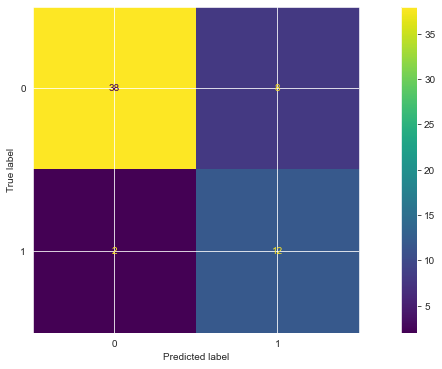

In [58]:
#Printing the classification report
print(classification_report(y_test, y_pred_rf_grid))

#Printing the confusion matrix
print(plot_confusion_matrix(rf_grid, X_test, y_test))